# GBM (Gradient Boosting Machine)

 `-` 다음은 [wikipedia](https://en.wikipedia.org/wiki/Gradient_boosting)의 Gradient Boosting Algorithm입니다. 다음의 수식을 먼저 읽고 최대한 이해하려고 노력해봅시다.

## Algorithm


-------------------
1. **initialize model with a constant value:**\
    $F_0(x) = \underset{\gamma}{\arg\min}\sum_{i=1}^n L(y_i, \gamma)$

 2. **For m = 1 to M**: 
    1. Compute so-called pseudo-residuals
       $r_{im} = - \Bigg[\displaystyle\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\Bigg]_{F(x) = F_{m-1}(x)}$ for $i = 1, ... ,n$
    2. Fit a base learner (or weak learner, e.g. tree) closed under scaling $h_m(x)$ to pseuo-residuals, i.e. train it using the training set $\{(x_i, r_{im})\}_{i=1}^{n}$
    3. Compute multiplier $\gamma_{m}$ by solving the following one-dimensional optimization problem:\
       $\gamma_m = \underset{\gamma}{\arg\min}\sum_{i=1}^n L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i))$
    4. Update the model:\
       $F_m(x) = F_{m-1}(x) + \gamma_m h_m(x)$
    
3. **Output $\hat{f(x)} = F_M(x)$**
-----------------------
   
       

수식으로만 완전히 이해하기가 어렵기 때문에 간단한 예시와 `pandas dataframe`을 이용하여 설명해보겠습니다.\
다음과 같은 데이터가 있다고 가정해보겠습니다.

In [3]:
import pandas as pd
idx = ['학생1', '학생2', '학생3', '학생4']
data = pd.DataFrame({'공부시간(m)':[150, 120, 60, 80], '성별':['여','남','남', '여'], '수학점수':[90, 65, 55, '???']},index=idx)
data

,공부시간(m),성별,수학점수
학생1,150,여,90
학생2,120,남,65
학생3,60,남,55
학생4,80,여,???


다음과 같은 데이터가 있다고 할 때, 저희는 학생4의 `수학점수`를 `공부시간(m)`을 통하여 예측하고 싶습니다.

#### **1단계**

----------------------
1. **initialize model with a constant value:**\
    $F_0(x) = \underset{\gamma}{\arg\min}\sum_{i=1}^n L(y_i, \gamma)$
-----------------------

1. 초기모델을 상수로 정의합니다. 여기서 상수는 $y_i$와 $\gamma$입니다.
2. $y_i$는 수학점수를 의미하고 $\gamma$는 초기 예측값입니다.
    - $y_1$ = 90,  $y_2$ = 65, $y_3$ = 60
3. 여기서의 Loss Function $L(y_i, \gamma) = \displaystyle\frac1n \sum_{i=1}^{n} (y_i - \gamma)^2$입니다. (잘 모르시는 분들은 MSE 학습하시면 좋을 것 같습니다.)
4. 예시의 수치를 대입하면\
$L(y_i, \gamma) = \displaystyle\frac13 \sum_{i=1}^{3} (y_i - \gamma)^2 =  \displaystyle\frac13(90 - \gamma)^2 + \displaystyle\frac13(65 - \gamma)^2 + \displaystyle\frac13(55 - \gamma)^2$입니다.
5. $L(y_i, \gamma)$가 최소가 되는 $\gamma$를 찾아야 하므로
$\displaystyle\frac{\partial L}{\partial \gamma} = \displaystyle\frac23(\gamma - 90) + \displaystyle\frac23(\gamma - 65) + \displaystyle\frac23(\gamma - 55) = \displaystyle\frac23(3\gamma - 210)$입니다.
6. $\displaystyle\frac{\partial L}{\partial \gamma} = 0$이 되어야 하므로 $\gamma$ = 70입니다. 따라서 초기 예측값 $\gamma$는 70이 됩니다.
7. 초기 예측값을 이용한 첫번째 잔차는 각각 20, -5, -15가 됩니다.
 

In [34]:
import pandas as pd
idx = ['Student1', 'Student2', 'Student3']
data = pd.DataFrame({'StudyTime(m)':[150, 120, 60], 'Sex':['female','male','male'], 
                     'MathScore':[90, 65, 55], 'F_0':[70 for i in range(3)],'r1': [20, -5, -15]},index=idx)
data

,StudyTime(m),Sex,MathScore,F_0,r1
Student1,150,female,90,70,20
Student2,120,male,65,70,-5
Student3,60,male,55,70,-15


`-` 위의 데이터를 의사결정나무로 시각화를 하면 다음과 같습니다.

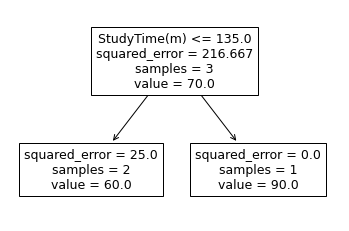

In [40]:
import sklearn.tree
## step1
x = data[['StudyTime(m)']]
y = data['MathScore']

## step2
predictr = sklearn.tree.DecisionTreeRegressor(max_depth=1)

## step3
predictr.fit(x,y)

## visualization
sklearn.tree.plot_tree(predictr,feature_names=x.columns);

#### **2단계**

-----------------------------------
 2. **For $m$ = 1 to $M$**: 
    1. Compute so-called pseudo-residuals
       $r_{im} = - \Bigg[\displaystyle\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\Bigg]_{F(x) = F_{m-1}(x)}$ for $i = 1, ... ,n$
    2. Fit a base learner (or weak learner, e.g. tree) closed under scaling $h_m(x)$ to pseuo-residuals, i.e. train it using the training set $\{(x_i, r_{im})\}_{i=1}^{n}$
    3. Compute multiplier $\gamma_{m}$ by solving the following one-dimensional optimization problem:\
       $\gamma_m = \underset{\gamma}{\arg\min}\sum_{i=1}^n L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i))$
    4. Update the model:\
       $F_m(x) = F_{m-1}(x) + \gamma_m h_m(x)$
-----------------------------------------    

1. `A단계`부터 `D단계`를 총 `M번` 반복하는 단계입니다.
2. 여기서 $M$은 예측기의 개수, $n$은 데이터의 개수입니다.
3. 예측기에 번호를 붙여 $m$=1인 경우는 1번 예측기 $m=M$인 경우는 M번 예측기라고 부르겠습니다.
4. 1번 예측기($m=1$)가 생성 되는 과정을 살펴보겠습니다. $L(y_i,F(x_i)) = \displaystyle\frac12(y_i - F(x_i))^2$이므로
    * $r_{i1} = - \Bigg[\displaystyle\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\Bigg]_{F(x) = F_{0}(x)} = y_i - F_0(x_i)$입니다. (잔차와 식이 동일합니다.)
    * 0번 예측기 $F_0(x)$는 1단계의 초기모델에서 생성되었습니다. 따라서 $F_0(x)=70$입니다.(1단계 참고)
    * 따라서 $r_{11}=20$, $r_{21}=-5$, $r_{31}=-15$입니다. 1단계 표에 있는 잔차1과 같습니다.
    * 함수$h_1(x)$는 앞서 계산한 잔차를 트리 계열로 학습합니다.(의사 결정 나무에 대해서는 추후에 업로드 하겠습니다.)
    * 모든 데이터($n=3$)에 대해서 $\sum_{i=1}^{3} L(y_i, F_0(x_i) + \gamma h_m(x_i)$ 식이 최소가 되는 $\gamma$(learning rate)를 찾습니다.($\gamma = \gamma_{1}$) 
    * 모델을 업데이트 합니다 : $F_1(x) = F_0(x) + \gamma_1 h_1(x)$
5. 4번의 과정을 M번 반복합니다.

`-` 추가설명

#### **3단계**

-----------------------------
3. **Output $\hat{f(x)} = F_M(x)$**
-----------------------------

1. 최종 모델을 산출합니다.

## Implementation